# **Lab 11: Final Projects**
---

### **Description**
In today's notebook, you will apply what you have learned throughout Part II, particularly with regards to Deep Learning and Natural Language Processsing, to several projects in order to reinforce these skills. We encourage you to not only solve the problems and follow the steps below, but to also consider how you could apply what else you've learned to each problem or in coming up with new problems to solve with the given datasets.

<br>

### **Lab Structure**
**Part 1**: [Heart Attack Predictor](#p1)

**Part 2**: [Amazon Review Sentiment Analysis](#p2)

**Part 3**: [Semantic Segmentation with U-Net](#p3)

**Part 4**: [Generating Wikipedia Entries](#p4)


<br>

### **Goals**
By the end of this lab, you will have honed the skills you have learned throughout the program and started to see how you could extend them to more complex situations.

<br>

### **Cheat Sheets**
* [EDA with pandas](https://docs.google.com/document/d/1FFoqw45P-kuoq912ARP4qfdGeLTqoq73_qjZThPp2_8/edit?usp=drive_link)

* [Data Visualization with matplotlib](https://docs.google.com/document/d/1YlUp6ll81qOyDpU1OWzE-SPxQ3hnF5C9ukLRL_6PYKE/edit?usp=drive_link)

* [Linear Regression with sklearn](https://docs.google.com/document/d/1iVieBynTpoKq1LA0kR-4pqDo6evoW5wvbNyE0wOGhYY/edit?usp=drive_link)

* [KNN with sklearn](https://docs.google.com/document/d/1U-AWXkJEDXZFqhBwFlDjyp9bLsVOeeXGYaxa6SZ7KpY/edit?usp=drive_link)

* [Logistic Regression with sklearn](https://docs.google.com/document/d/1Xi4fXFROik5Rs6C0d3oIM-OmK3pvw7MwkvM3TJw7vn4/edit?usp=drive_link)

* [Deep Learning with pytorch](https://docs.google.com/document/d/1Wm01maZUrSuwdOhuI05uZBtqt5nL5shOGnJ7kTHWl_I/edit?usp=drive_link)

* [CNNs with pytorch](https://docs.google.com/document/d/15UV1gVy5J6fzAD5vYyikiprew4erlR9Fop66h89ql0w/edit?usp=drive_link)

* [Natural Language Processing I](https://docs.google.com/document/d/1MamYMxe8zlWoiDc0tX2RzUKQULCPVUh-2QtdzRRvzcs/edit?usp=drive_link)

* [Natural Language Processing II](https://docs.google.com/document/d/1OoP-sFW6qMk0BzvYMlavgJtiXX9eziTUptlFdzgLfGk/edit?usp=drive_link)

* [Natural Language Processing III](https://docs.google.com/document/d/1jrzya_r_97qrmk7RGKqWCPhkHhsKMsMDkrn7YjdZUK0/edit?usp=drive_link)

<br>

**Before starting, run the code below to import all necessary functions and libraries.**


In [ ]:
!pip --quiet install scikit-learn scikit-optimize
!pip --quiet install torchview torch graphviz
!pip --quiet install fastai
!pip --quiet install hyperopt
!conda install -q python-graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 62.9 MB/s eta 0:00:00
/bin/bash: line 1: conda: command not found


In [ ]:
import os
import random
from random import choices

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from fastai.vision.all import *
from fastai.text.all import *
from fastai.optimizer import Adam

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *


from skopt import BayesSearchCV
from skopt.space import Integer
from hyperopt import fmin, tpe, rand, hp, Trials, STATUS_OK

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0


def binary_accuracy(y_pred, y_true):
    # Output 0 if y_pred <= 0.5 and 1 if y_pred is > 0.5
    y_pred = (y_pred > 0.5).float()
    # Returns accuracy
    return (y_pred == y_true).float().mean()

<a name="p1"></a>

---
## **Part 1: Heart Attack Predictor**
---

Your goal in this section is to use KNN and a neural network to predict whether a given patient is likely to have a heart attack or not. Specifically, the dataset has:

* **Features**: `'age'`, `'sex'`, `'cp'`, `'trestbps'`, `'chol'`, `'fbs'`, `'restecg'`, `'thalach'`, `'exang'`, `'oldpeak'` that describe a variety of health statistics taken by doctors for a given patient.

* **Target**: `'heart attack'` which is 0 if the patient has not had a heart attack and 1 if the patient has had a heart attack.


<br>

**Run the code provided below to import the dataset and split into training and test sets.**

In [ ]:
# Load the data into a DataFrame
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSa0metcKBFqn-MHLn05vVGWONMlzljcWa-xIM1wJPXIa5kbrmIzGqmWcMh8eKG_ntByF9qqn6Mx3MT/pub?gid=1052859518&single=true&output=csv'
df = pd.read_csv(url)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    df.drop(columns = 'heart attack'),
    df['heart attack'],
    test_size = 0.2,
    random_state = 42)

# Define a custom function for creating a DataLoader from features and target data
def create_dataloader(X,y):
  X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
  y_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32).unsqueeze(1)
  dataset = list(zip(X_tensor, y_tensor))
  dl = DataLoader(dataset, batch_size=64, shuffle=True)
  return dl

# Define the DataLoaders
train_dl = create_dataloader(X_train, y_train)
valid_dl = create_dataloader(X_valid, y_valid)
dls = DataLoaders(train_dl, valid_dl)

# Define DataLoaders for female subset
train_dl_female = create_dataloader(
    X_train[X_train['sex']==0],
    y_train[X_train['sex']==0])
valid_dl_female = create_dataloader(
    X_valid[X_valid['sex']==0],
    y_valid[X_valid['sex']==0])
dls_female = DataLoaders(train_dl_female, valid_dl_female)

# Define DataLoaders for male subset
train_dl_male = create_dataloader(
    X_train[X_train['sex']==1],
    y_train[X_train['sex']==1])
valid_dl_male = create_dataloader(
    X_valid[X_valid['sex']==1],
    y_valid[X_valid['sex']==1])
dls_male = DataLoaders(train_dl_male, valid_dl_male)

#### **Problem #1.1: Use a KNN classifier**


Train a KNN model to perform this task. Try multiple values of K (`n_neighbors`) to achieve the highest performance you can on the training and validation data. Consider using random search, grid search, or bayesian optimization to find the best value of K.

In [ ]:
# Define the KNN Classifier


# Train the model


# Make predictions
y_pred = # COMPLETE THIS CODE

train_accuracy = accuracy_score(y_train, # COMPLETE THIS CODE
valid_accuracy = accuracy_score(# COMPLETE THIS CODE

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {valid_accuracy:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_valid, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

plt.xticks(rotation = 90)
plt.show()

###### **Solution**


Best K value:  13
Training accuracy: 0.6779
Validation accuracy: 0.6226


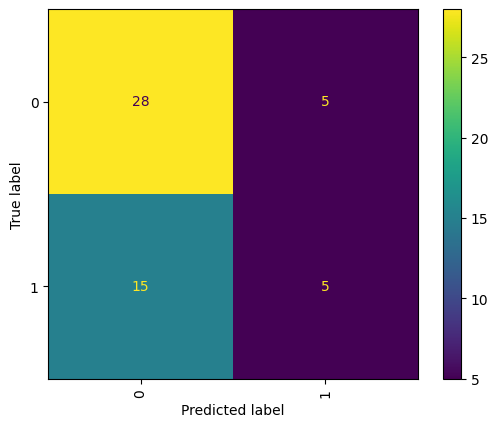

In [ ]:
# A strangely necessary fix for using BayesSearchCV that others have raised, but has not been addressed yet :/
np.int = int

# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter search space
search_spaces_knn = {
    'n_neighbors': Integer(1, len(X_train)//10)
}

# Use BayesSearchCV
bayes_search_knn = BayesSearchCV(estimator=knn, search_spaces=search_spaces_knn, n_iter=10, cv=10)
bayes_search_knn_result = bayes_search_knn.fit(X_train, y_train)

k = bayes_search_knn_result.best_params_['n_neighbors']
print('Best K value: ', k)


# Train the final model
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_valid)

train_accuracy = accuracy_score(y_train, knn.predict(X_train))
valid_accuracy = accuracy_score(y_valid, y_pred)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {valid_accuracy:.4f}")

cm = confusion_matrix(y_valid, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

plt.xticks(rotation = 90)
plt.show()

#### **Problem #1.2: Use a fully connected neural network**

Train a fully connected network to perform this task. Change model architechure and hyperparameters to improve the model, particularly using regularization and hyperparameter tuning techniques. What's the highest accuracy you are able to achieve on the validation set?

In [ ]:
# @title
# Hyperparameter search
# Define the objective function to minimize (Hyperopt minimizes the loss, so we negate accuracy)
def objective(params):

    # COMPLETE THIS CODE



# Define the search space
space = {
    # COMPLETE THIS CODE
}

# Perform optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)




# Train the best model
# Get the best parameters and best score
best_params = {k: best[k] for k in best}
best_score = -trials.best_trial['result']['loss']


model = nn.Sequential(
  # COMPLETE THIS CODE
)

# COMPLETE THIS CODE

learn = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy, # COMPLETE THIS CODE
learn.fit(# COMPLETE THIS CODE



# Calculate training accuracy
train_loss, train_accuracy = learn.validate(# COMPLETE THIS CODE
print(f"Training accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
valid_loss, valid_accuracy = learn.validate(# COMPLETE THIS CODE
print(f"Validation accuracy: {valid_accuracy:.4f}")

###### **Solution**


In [ ]:
# Define the objective function to minimize (Hyperopt minimizes the loss, so we negate accuracy)
def objective(params):

    model = nn.Sequential(
      nn.Linear(10, params['neurons_1']),
      nn.ReLU(),
      nn.Dropout(p=params['drop']),
      nn.Linear(params['neurons_1'], params['neurons_2']),
      nn.ReLU(),
      nn.Linear(params['neurons_2'], 1),
      nn.Sigmoid()
    )

    es_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

    loss_func = nn.BCELoss()
    learn = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy, cbs = [es_cb], wd = params['l2'])
    learn.fit(10, lr=params['learning_rate'])

    valid_loss, valid_accuracy = learn.validate()

    return {'loss': -valid_accuracy, 'status': STATUS_OK}



# Define the search space
space = {
    'neurons_1': hp.randint('neurons_1', 4, 512),
    'neurons_2': hp.randint('neurons_2', 4, 512),
    'drop': hp.uniform('drop', 0, 1),
    'l2': hp.loguniform('l2', np.log(1e-6), np.log(1e-2)),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-6), np.log(1e-1))
}

# Perform optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Get the best parameters and best score
best_params = {k: best[k] for k in best}
best_score = -trials.best_trial['result']['loss']


model = nn.Sequential(
  nn.Linear(10, int(best_params['neurons_1'])),
  nn.ReLU(),
  nn.Dropout(p=float(best_params['drop'])),
  nn.Linear(int(best_params['neurons_1']), int(best_params['neurons_2'])),
  nn.ReLU(),
  nn.Linear(int(best_params['neurons_2']), 1),
  nn.Sigmoid()
)

es_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

loss_func = nn.BCELoss()
learn = Learner(dls, model, loss_func=loss_func, metrics=binary_accuracy, cbs = [es_cb], wd = float(best_params['l2']))
learn.fit(10, lr=float(best_params['learning_rate']))




print("Best Parameters:", best_params)
print("Best Score:", best_score)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,binary_accuracy,time
0,36.343487,4.727520,0.377358,00:00
1,41.327629,4.707181,0.377358,00:00
2,42.373524,4.688372,0.377358,00:00
3,40.284874,4.669154,0.377358,00:00
4,39.530193,4.648790,0.377358,00:00
5,40.402809,4.629287,0.377358,00:00
6,40.889668,4.610398,0.377358,00:00
7,41.274063,4.591728,0.377358,00:00
8,40.975536,4.573662,0.377358,00:00
9,41.472420,4.554405,0.377358,00:00


  5%|▌         | 1/20 [00:00<00:09,  2.05trial/s, best loss: -0.37735849618911743]

epoch,train_loss,valid_loss,binary_accuracy,time
0,5.118320,2.903195,0.377358,00:00
1,4.749158,1.745668,0.622642,00:00
2,4.185933,1.016575,0.584906,00:00
3,4.068607,0.969672,0.622642,00:00
4,3.681608,1.809325,0.679245,00:00
5,3.373431,1.348564,0.584906,00:00
6,3.167712,1.056372,0.660377,00:00


No improvement since epoch 3: early stopping
  5%|▌         | 1/20 [00:00<00:09,  2.05trial/s, best loss: -0.37735849618911743]

 10%|█         | 2/20 [00:00<00:07,  2.55trial/s, best loss: -0.6603773832321167] 

epoch,train_loss,valid_loss,binary_accuracy,time
0,4.264025,3.900112,0.622642,00:00
1,3.561970,0.920350,0.603774,00:00
2,2.907545,1.048214,0.698113,00:00
3,2.457105,0.722914,0.660377,00:00
4,2.103455,0.752362,0.698113,00:00
5,1.861432,0.676843,0.603774,00:00
6,1.740312,0.729301,0.679245,00:00
7,1.606237,0.691803,0.603774,00:00
8,1.513443,0.782838,0.735849,00:00


No improvement since epoch 5: early stopping
 10%|█         | 2/20 [00:01<00:07,  2.55trial/s, best loss: -0.6603773832321167]

 15%|█▌        | 3/20 [00:01<00:07,  2.29trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,6.772981,4.481290,0.622642,00:00
1,7.397994,4.392172,0.622642,00:00
2,7.194451,4.317164,0.622642,00:00
3,7.265394,4.244713,0.622642,00:00
4,7.197500,4.168527,0.622642,00:00
5,7.060740,4.087319,0.622642,00:00
6,6.878606,4.008816,0.622642,00:00
7,7.063097,3.937614,0.622642,00:00
8,7.032595,3.875795,0.622642,00:00
9,7.077605,3.813045,0.622642,00:00


 20%|██        | 4/20 [00:01<00:06,  2.31trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,2.928148,1.898060,0.377358,00:00
1,2.452542,0.654604,0.660377,00:00
2,2.105667,1.511194,0.622642,00:00
3,1.862596,0.645837,0.641509,00:00
4,1.669666,0.909486,0.490566,00:00


No improvement since epoch 1: early stopping
 20%|██        | 4/20 [00:01<00:06,  2.31trial/s, best loss: -0.7358490824699402]

 25%|██▌       | 5/20 [00:02<00:05,  2.62trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,6.464200,3.873549,0.377358,00:00
1,4.906796,1.548362,0.396226,00:00
2,3.746229,0.814970,0.566038,00:00
3,3.033128,1.429571,0.622642,00:00
4,2.706158,1.753289,0.622642,00:00
5,2.505927,1.581955,0.622642,00:00


No improvement since epoch 2: early stopping
 25%|██▌       | 5/20 [00:02<00:05,  2.62trial/s, best loss: -0.7358490824699402]

 30%|███       | 6/20 [00:02<00:05,  2.61trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,34.770897,7.858754,0.377358,00:00
1,30.822453,4.656384,0.377358,00:00
2,25.595522,1.534226,0.377358,00:00
3,19.677216,0.849496,0.660377,00:00
4,16.519098,2.141019,0.622642,00:00
5,13.563816,2.933357,0.622642,00:00
6,11.611835,3.264945,0.622642,00:00


No improvement since epoch 3: early stopping
 30%|███       | 6/20 [00:02<00:05,  2.61trial/s, best loss: -0.7358490824699402]

 35%|███▌      | 7/20 [00:02<00:04,  2.61trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,2.737118,1.420700,0.622642,00:00
1,2.937818,1.426444,0.622642,00:00
2,3.036080,0.853964,0.622642,00:00
3,2.839227,0.611785,0.698113,00:00
4,2.669707,0.619504,0.660377,00:00
5,2.483968,0.929974,0.622642,00:00
6,2.423518,1.221723,0.622642,00:00


No improvement since epoch 3: early stopping
 35%|███▌      | 7/20 [00:03<00:04,  2.61trial/s, best loss: -0.7358490824699402]

 40%|████      | 8/20 [00:03<00:04,  2.52trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,2.187365,0.701878,0.622642,00:00
1,1.596636,0.638325,0.698113,00:00
2,1.451417,0.636491,0.584906,00:00
3,1.300616,0.631652,0.584906,00:00
4,1.287209,0.792519,0.641509,00:00


No improvement since epoch 1: early stopping
 40%|████      | 8/20 [00:03<00:04,  2.52trial/s, best loss: -0.7358490824699402]

 45%|████▌     | 9/20 [00:03<00:04,  2.58trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,1.007542,0.741144,0.622642,00:00
1,0.953273,0.692097,0.622642,00:00
2,0.884293,0.658010,0.622642,00:00
3,0.859872,0.639339,0.603774,00:00
4,0.836990,0.630097,0.603774,00:00
5,0.816825,0.627680,0.603774,00:00
6,0.799437,0.628843,0.603774,00:00
7,0.800013,0.629808,0.641509,00:00
8,0.796547,0.630013,0.660377,00:00


No improvement since epoch 5: early stopping
 45%|████▌     | 9/20 [00:04<00:04,  2.58trial/s, best loss: -0.7358490824699402]

 50%|█████     | 10/20 [00:04<00:04,  2.33trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,11.295856,9.804512,0.622642,00:00
1,8.556814,4.522911,0.377358,00:00
2,7.443344,0.928988,0.452830,00:00
3,5.828888,2.686120,0.622642,00:00
4,4.877892,1.135293,0.509434,00:00
5,4.217241,0.658146,0.641509,00:00
6,3.652113,1.394621,0.660377,00:00
7,3.245687,0.748865,0.679245,00:00
8,2.899036,0.688745,0.660377,00:00


No improvement since epoch 5: early stopping
 50%|█████     | 10/20 [00:04<00:04,  2.33trial/s, best loss: -0.7358490824699402]

 55%|█████▌    | 11/20 [00:04<00:03,  2.26trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,39.709534,37.735847,0.622642,00:00
1,37.037750,37.735847,0.622642,00:00
2,38.013031,37.735847,0.622642,00:00
3,35.928070,37.735847,0.622642,00:00


No improvement since epoch 0: early stopping
 55%|█████▌    | 11/20 [00:04<00:03,  2.26trial/s, best loss: -0.7358490824699402]

 60%|██████    | 12/20 [00:04<00:02,  2.72trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,35.842857,37.735847,0.622642,00:00
1,37.961185,37.735847,0.622642,00:00
2,37.359283,37.735847,0.622642,00:00
3,38.077721,37.735847,0.622642,00:00


No improvement since epoch 0: early stopping
 60%|██████    | 12/20 [00:04<00:02,  2.72trial/s, best loss: -0.7358490824699402]

 65%|██████▌   | 13/20 [00:05<00:02,  3.07trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,13.527691,0.848663,0.547170,00:00
1,13.400526,0.851303,0.547170,00:00
2,12.658993,0.862132,0.547170,00:00
3,12.778517,0.869494,0.547170,00:00


No improvement since epoch 0: early stopping
 65%|██████▌   | 13/20 [00:05<00:02,  3.07trial/s, best loss: -0.7358490824699402]

 70%|███████   | 14/20 [00:05<00:01,  3.49trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,6.007671,5.479562,0.622642,00:00
1,5.656382,5.445917,0.622642,00:00
2,5.951168,5.412505,0.622642,00:00
3,5.867399,5.378553,0.622642,00:00
4,5.824651,5.344611,0.622642,00:00
5,5.894803,5.310642,0.622642,00:00
6,5.830315,5.276865,0.622642,00:00
7,5.793378,5.242903,0.622642,00:00
8,5.749220,5.208665,0.622642,00:00
9,5.669262,5.175119,0.622642,00:00


 75%|███████▌  | 15/20 [00:05<00:01,  2.62trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,13.630502,1.615996,0.622642,00:00
1,11.786250,0.691891,0.622642,00:00
2,10.344889,0.636873,0.679245,00:00
3,10.378608,1.246486,0.377358,00:00
4,10.433219,1.972045,0.377358,00:00
5,10.295747,1.959640,0.377358,00:00


No improvement since epoch 2: early stopping
 75%|███████▌  | 15/20 [00:06<00:01,  2.62trial/s, best loss: -0.7358490824699402]

 80%|████████  | 16/20 [00:06<00:01,  2.63trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,20.984322,3.944595,0.377358,00:00
1,11.425214,1.839789,0.622642,00:00
2,8.139544,3.008538,0.622642,00:00
3,6.671932,2.046387,0.622642,00:00
4,5.551521,0.599656,0.716981,00:00
5,4.721260,1.045045,0.377358,00:00
6,4.198090,0.574541,0.698113,00:00
7,3.748488,1.061212,0.622642,00:00
8,3.371625,0.933629,0.622642,00:00
9,3.071192,0.629633,0.679245,00:00


No improvement since epoch 6: early stopping
 80%|████████  | 16/20 [00:06<00:01,  2.63trial/s, best loss: -0.7358490824699402]

 85%|████████▌ | 17/20 [00:06<00:01,  2.10trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,13.095631,13.682045,0.622642,00:00
1,12.921589,3.304629,0.622642,00:00
2,9.592153,1.886598,0.622642,00:00
3,7.611990,1.904205,0.433962,00:00
4,6.256433,1.680940,0.622642,00:00
5,5.314816,0.812961,0.622642,00:00
6,4.603801,0.882155,0.660377,00:00
7,4.060552,0.785701,0.622642,00:00
8,3.625429,0.750294,0.698113,00:00
9,3.273781,0.606878,0.660377,00:00


 90%|█████████ | 18/20 [00:07<00:00,  2.10trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,19.421701,3.283565,0.377358,00:00
1,13.995413,0.906442,0.660377,00:00
2,11.001255,0.819394,0.622642,00:00
3,9.747031,0.887357,0.584906,00:00
4,8.548837,1.300860,0.622642,00:00
5,8.595868,1.838539,0.528302,00:00


No improvement since epoch 2: early stopping
 90%|█████████ | 18/20 [00:07<00:00,  2.10trial/s, best loss: -0.7358490824699402]

 95%|█████████▌| 19/20 [00:07<00:00,  2.21trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,49.641438,62.264153,0.377358,00:00
1,58.215321,62.264153,0.377358,00:00
2,59.299355,62.264153,0.377358,00:00
3,59.524258,62.264153,0.377358,00:00


No improvement since epoch 0: early stopping
 95%|█████████▌| 19/20 [00:07<00:00,  2.21trial/s, best loss: -0.7358490824699402]

100%|██████████| 20/20 [00:08<00:00,  2.49trial/s, best loss: -0.7358490824699402]


epoch,train_loss,valid_loss,binary_accuracy,time
0,4.312953,1.023542,0.622642,00:00
1,4.002781,0.921995,0.660377,00:00
2,3.334374,2.194649,0.622642,00:00
3,2.903402,1.854222,0.509434,00:00
4,2.538138,1.744866,0.660377,00:00


No improvement since epoch 1: early stopping
Best Parameters: {'drop': 0.04349282949978861, 'l2': 4.395707552464344e-05, 'learning_rate': 0.00036328200906235187, 'neurons_1': 443, 'neurons_2': 378}
Best Score: 0.7358490824699402


#### **Reflection Questions**
* Which of your models performed better?
* Does deep learning always outperform traditional ML?
* What kinds of problems are best-suited for deep learning?

In [ ]:
'''
# WRITE YOUR RESPONSES HERE
''';

#### **Problem #1.3: Evaluate for Females and Males Separately**


Now, evaluate both of your models for females and males separately to see if there's any difference in the performance of your high performing models. You can just print the validation accuracy.

##### **1. Evaluate KNN for Female vs. Male.**

In [ ]:
female_rows = X_valid['sex']==0
male_rows = # COMPLETE THIS CODE

female_preds = knn.predict(X_valid[female_rows])
male_preds = # COMPLETE THIS CODE

accuracy_female = accuracy_score(y_valid[female_rows], # COMPLETE THIS CODE
accuracy_male = accuracy_score( # COMPLETE THIS CODE
print(f"Female validation accuracy: {accuracy_female:.4f}")
print(f"Male validation accuracy: {accuracy_male:.4f}")

###### **Solution**


In [ ]:
female_rows = X_valid['sex']==0
male_rows = X_valid['sex']==1

female_preds = knn.predict(X_valid[female_rows])
male_preds = knn.predict(X_valid[male_rows])

accuracy_female = accuracy_score(y_valid[female_rows], female_preds)
accuracy_male = accuracy_score(y_valid[male_rows], male_preds)
print(f"Female validation accuracy: {accuracy_female:.4f}")
print(f"Male validation accuracy: {accuracy_male:.4f}")

Female validation accuracy: 1.0000
Male validation accuracy: 0.6000


##### **2. Evaluate NN for Female vs. Male.**

**NOTE**: We have already created a separated female and male train and validation data loader that you can use called: `train_dl_female`, `valid_dl_female`, `train_dl_male`, and `valid_dl_male`.

In [ ]:
# Calculate female training and validation accuracy
_, train_accuracy_female = learn.validate(# COMPLETE THIS CODE
print(f"Female training accuracy: {train_accuracy_female:.4f}")

_, valid_accuracy_female = learn.validate(# COMPLETE THIS CODE
print(f"Female validation accuracy: {valid_accuracy_female:.4f}")


# Calculate male training and validation accuracy
_, train_accuracy_male = learn.validate(# COMPLETE THIS CODE
print(f"Male training accuracy: {train_accuracy_male:.4f}")

_, valid_accuracy_male = learn.validate(# COMPLETE THIS CODE
print(f"Male validation accuracy: {valid_accuracy_male:.4f}")

###### **Solution**


In [ ]:
# Calculate female training and validation accuracy
_, train_accuracy_female = learn.validate(dl=train_dl_female)
print(f"Female training accuracy: {train_accuracy_female:.4f}")

_, valid_accuracy_female = learn.validate(dl=valid_dl_female)
print(f"Female validation accuracy: {valid_accuracy_female:.4f}")


# Calculate male training and validation accuracy
_, train_accuracy_male = learn.validate(dl=train_dl_male)
print(f"Male training accuracy: {train_accuracy_male:.4f}")

_, valid_accuracy_male = learn.validate(dl=valid_dl_male)
print(f"Male validation accuracy: {valid_accuracy_male:.4f}")

Female training accuracy: 0.8197


Female validation accuracy: 1.0000


Male training accuracy: 0.5918


Male validation accuracy: 0.6000


#### **Problem #1.4: Examine why**


You likely saw a noticeable difference in the performance between females and males for both models. Examine why this might be by doing the following:

1. Plot a bar chart of the number of males vs. females in this data.
2. Plot a grouped bar chart of the number of males and females that did not have a heart attack vs. those that did.

##### **1. Plot a bar chart of the number of males vs. females in this data.**

In [ ]:
plt.bar(['Female', 'Male'], df['sex'].# COMPLETE THIS CODE

# COMPLETE THIS CODE

###### **Solution**


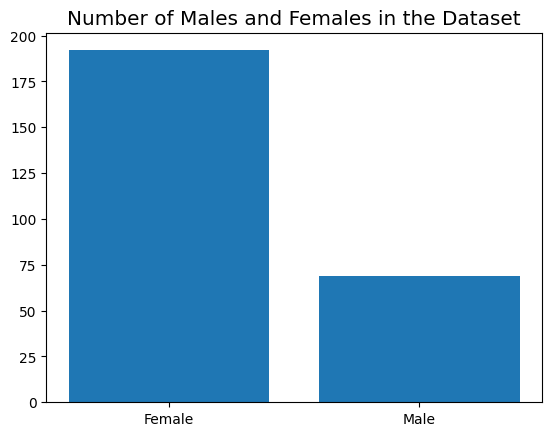

In [ ]:
plt.bar(['Female', 'Male'], df['sex'].value_counts())

plt.title('Number of Males and Females in the Dataset', fontsize = 'x-large')
plt.show()

##### **2. Plot a grouped bar chart of the number of males and females that did not have a heart attack vs. those that did.**

In [ ]:
df_female = df[df['sex'] == 0]
df_male = df[df['sex'] == 1]

plt.bar([-0.1, 0.9], # COMPLETE THIS CODE
plt.bar([0.1, 1.1], # COMPLETE THIS CODE

plt.xticks(ticks = [0, 1], labels = ['No Heart Attack', 'Heart Attack'], fontsize = 'x-large')
plt.title('Breakdown of Heart Attacks by Sex', fontsize = 'x-large')
plt.legend()
plt.show()

###### **Solution**


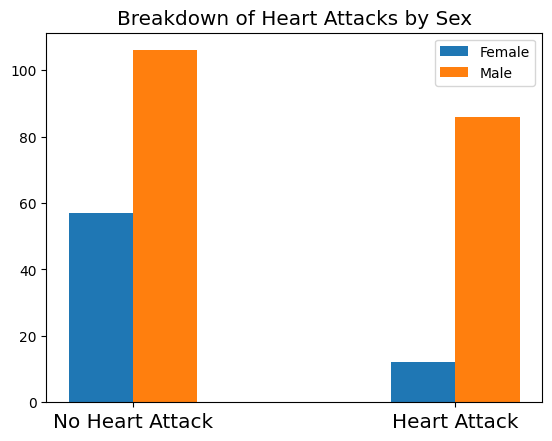

In [ ]:
df_female = df[df['sex'] == 0]
df_male = df[df['sex'] == 1]

plt.bar([-0.1, 0.9], df_female['heart attack'].value_counts(), label = 'Female', width = 0.2)
plt.bar([0.1, 1.1], df_male['heart attack'].value_counts(), label = 'Male', width = 0.2)

plt.xticks(ticks = [0, 1], labels = ['No Heart Attack', 'Heart Attack'], fontsize = 'x-large')
plt.title('Breakdown of Heart Attacks by Sex', fontsize = 'x-large')
plt.legend()
plt.show()

#### **Problem #1.5: What if we blind the models to this variable?**


A common approach to avoid bias is to take a "blind" approach, in which we remove the biased variable from the equation. In this case, we'll do that by training new models using data without the `'sex'` column. Specifically,

1. Train and evaluate an KNN Classifier on the blind data.
2. Train and evaluate a NN on the blind data.

In both cases, evaluate the models separately on the female and male rows just as you did in Problem #3.

<br>

**Run the code below before starting to create the blind data.**

In [ ]:
X_train_blind = X_train.drop(columns=['sex'])
X_valid_blind = X_valid.drop(columns=['sex'])

##### **1. Train and evaluate a KNN Classifier on the blind data.**

In [ ]:
# COMPLETE THIS CODE

###### **Solution**


Best K value:  2
Validation accuracy overall: 0.6792452830188679
Validation accuracy for females: 0.875
Validation accuracy for males: 0.6444444444444445


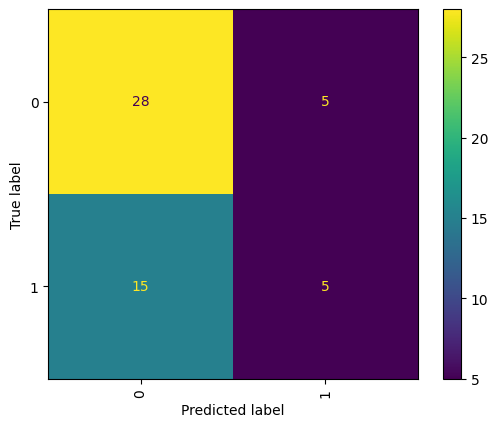

In [ ]:
# A strangely necessary fix for using BayesSearchCV that others have raised, but has not been addressed yet :/
np.int = int

# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter search space
search_spaces_knn = {
    'n_neighbors': Integer(1, len(X_train_blind)//10)
}

# Use BayesSearchCV
bayes_search_knn = BayesSearchCV(estimator=knn, search_spaces=search_spaces_knn, n_iter=10, cv=10)
bayes_search_knn_result = bayes_search_knn.fit(X_train_blind, y_train)

k = bayes_search_knn_result.best_params_['n_neighbors']
print('Best K value: ', k)


# Train the final model
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train_blind, y_train)

print("Validation accuracy overall: " + str(accuracy_score(y_valid, knn.predict(X_valid_blind))))
print("Validation accuracy for females: " + str(accuracy_score(y_valid[female_rows], knn.predict(X_valid_blind[female_rows]))))
print("Validation accuracy for males: " + str(accuracy_score(y_valid[male_rows], knn.predict(X_valid_blind[male_rows]))))

cm = confusion_matrix(y_valid, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

plt.xticks(rotation = 90)
plt.show()

##### **2. Train and evaluate a neural net on the blind data.**

First, run the cell below to set up the dataloaders.


In [ ]:
train_dl_blind = create_dataloader(X_train_blind, y_train)
valid_dl_blind = create_dataloader(X_valid_blind, y_valid)
dls_blind = DataLoaders(train_dl_blind, valid_dl_blind)

In [ ]:
# Perform hyperparameter search


# Train the model


# Calculate overall training and validation accuracy


# Calculate female training and validation accuracy


# Calculate male training and validation accuracy


###### **Solution**


In [ ]:
# Define the objective function to minimize (Hyperopt minimizes the loss, so we negate accuracy)
def objective(params):

    model = nn.Sequential(
      nn.Linear(9, params['neurons_1']),
      nn.ReLU(),
      nn.Dropout(p=params['drop']),
      nn.Linear(params['neurons_1'], params['neurons_2']),
      nn.ReLU(),
      nn.Linear(params['neurons_2'], 1),
      nn.Sigmoid()
    )

    es_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

    loss_func = nn.BCELoss()
    learn = Learner(dls_blind, model, loss_func=loss_func, metrics=binary_accuracy, cbs = [es_cb], wd = params['l2'])
    learn.fit(10, lr=params['learning_rate'])

    valid_loss, valid_accuracy = learn.validate()

    return {'loss': -valid_accuracy, 'status': STATUS_OK}



# Define the search space
space = {
    'neurons_1': hp.randint('neurons_1', 4, 512),
    'neurons_2': hp.randint('neurons_2', 4, 512),
    'drop': hp.uniform('drop', 0, 1),
    'l2': hp.loguniform('l2', np.log(1e-6), np.log(1e-2)),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-6), np.log(1e-1))
}

# Perform optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Get the best parameters and best score
best_params = {k: best[k] for k in best}
best_score = -trials.best_trial['result']['loss']


model_blind = nn.Sequential(
  nn.Linear(9, int(best_params['neurons_1'])),
  nn.ReLU(),
  nn.Dropout(p=float(best_params['drop'])),
  nn.Linear(int(best_params['neurons_1']), int(best_params['neurons_2'])),
  nn.ReLU(),
  nn.Linear(int(best_params['neurons_2']), 1),
  nn.Sigmoid()
)

es_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

loss_func = nn.BCELoss()
learn_blind = Learner(dls_blind, model_blind, loss_func=loss_func, metrics=binary_accuracy, cbs = [es_cb], wd = float(best_params['l2']))
learn_blind.fit(10, lr=float(best_params['learning_rate']))




print("Best Parameters:", best_params)
print("Best Score:", best_score)


# Calculate blind training and validation accuracy
_, train_accuracy_blind = learn_blind.validate(dl=train_dl_blind)
print(f"\n\nBlind training accuracy: {train_accuracy_blind:.4f}")

_, valid_accuracy_blind = learn_blind.validate(dl=valid_dl_blind)
print(f"Blind validation accuracy: {valid_accuracy:.4f}")


# Calculate female training and validation accuracy
_, train_accuracy_female = learn.validate(dl=train_dl_female)
print(f"\nFemale training accuracy: {train_accuracy_female:.4f}")

_, valid_accuracy_female = learn.validate(dl=valid_dl_female)
print(f"Female validation accuracy: {valid_accuracy_female:.4f}")


# Calculate male training and validation accuracy
_, train_accuracy_male = learn.validate(dl=train_dl_male)
print(f"\nMale training accuracy: {train_accuracy_male:.4f}")

_, valid_accuracy_male = learn.validate(dl=valid_dl_male)
print(f"Male validation accuracy: {valid_accuracy_male:.4f}")

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,binary_accuracy,time
0,31.852766,37.735847,0.622642,00:00
1,34.166054,37.735847,0.622642,00:00
2,35.331516,37.735847,0.622642,00:00
3,36.284863,37.735847,0.622642,00:00


No improvement since epoch 0: early stopping
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

  5%|▌         | 1/20 [00:00<00:03,  5.20trial/s, best loss: -0.6226415038108826]

epoch,train_loss,valid_loss,binary_accuracy,time
0,5.532390,2.767701,0.622642,00:00
1,5.558393,2.996348,0.622642,00:00
2,4.832767,3.255085,0.622642,00:00
3,4.420187,2.966092,0.622642,00:00


No improvement since epoch 0: early stopping
  5%|▌         | 1/20 [00:00<00:03,  5.20trial/s, best loss: -0.6226415038108826]

 10%|█         | 2/20 [00:00<00:03,  5.57trial/s, best loss: -0.6226415038108826]

epoch,train_loss,valid_loss,binary_accuracy,time
0,40.101711,34.384716,0.377358,00:00
1,30.443401,24.412809,0.622642,00:00
2,31.989288,37.735847,0.622642,00:00
3,33.805202,37.735847,0.622642,00:00
4,35.198780,37.735847,0.622642,00:00


No improvement since epoch 1: early stopping
 10%|█         | 2/20 [00:00<00:03,  5.57trial/s, best loss: -0.6226415038108826]

 15%|█▌        | 3/20 [00:00<00:03,  4.65trial/s, best loss: -0.6226415038108826]

epoch,train_loss,valid_loss,binary_accuracy,time
0,6.881412,0.955102,0.339623,00:00
1,6.091620,1.757373,0.622642,00:00
2,5.214902,1.321312,0.622642,00:00
3,5.065221,0.767183,0.509434,00:00
4,4.803080,1.157470,0.433962,00:00
5,5.062170,1.364204,0.433962,00:00
6,4.799066,0.940090,0.415094,00:00


No improvement since epoch 3: early stopping
 15%|█▌        | 3/20 [00:00<00:03,  4.65trial/s, best loss: -0.6226415038108826]

 20%|██        | 4/20 [00:00<00:04,  3.78trial/s, best loss: -0.6226415038108826]

epoch,train_loss,valid_loss,binary_accuracy,time
0,25.336834,37.735847,0.622642,00:00
1,30.378954,37.735847,0.622642,00:00
2,32.092709,37.735847,0.622642,00:00
3,33.279572,37.735847,0.622642,00:00


No improvement since epoch 0: early stopping
 20%|██        | 4/20 [00:01<00:04,  3.78trial/s, best loss: -0.6226415038108826]

 25%|██▌       | 5/20 [00:01<00:03,  4.07trial/s, best loss: -0.6226415038108826]

epoch,train_loss,valid_loss,binary_accuracy,time
0,34.910587,37.735847,0.622642,00:00
1,36.922451,37.735847,0.622642,00:00
2,37.560543,37.735847,0.622642,00:00
3,37.530338,37.735847,0.622642,00:00


No improvement since epoch 0: early stopping
 25%|██▌       | 5/20 [00:01<00:03,  4.07trial/s, best loss: -0.6226415038108826]

 30%|███       | 6/20 [00:01<00:03,  4.21trial/s, best loss: -0.6226415038108826]

epoch,train_loss,valid_loss,binary_accuracy,time
0,12.352989,4.860256,0.622642,00:00
1,12.202832,4.638428,0.622642,00:00
2,12.023494,4.408764,0.622642,00:00
3,11.371615,4.188767,0.622642,00:00
4,11.339681,3.988420,0.622642,00:00
5,11.686056,3.776994,0.622642,00:00
6,11.673515,3.566691,0.622642,00:00
7,11.710793,3.368787,0.622642,00:00
8,12.150806,3.161875,0.622642,00:00
9,12.452178,2.944058,0.622642,00:00


 35%|███▌      | 7/20 [00:01<00:04,  3.19trial/s, best loss: -0.6226415038108826]

epoch,train_loss,valid_loss,binary_accuracy,time
0,18.957317,16.742661,0.622642,00:00
1,15.021547,3.914987,0.622642,00:00
2,15.814166,3.959538,0.377358,00:00
3,15.090098,5.974244,0.622642,00:00
4,13.056342,1.205320,0.660377,00:00
5,13.512608,2.846833,0.396226,00:00
6,12.961861,2.781101,0.622642,00:00
7,11.438223,1.366400,0.716981,00:00


No improvement since epoch 4: early stopping
 35%|███▌      | 7/20 [00:02<00:04,  3.19trial/s, best loss: -0.6226415038108826]

 40%|████      | 8/20 [00:02<00:04,  2.82trial/s, best loss: -0.7169811129570007]

epoch,train_loss,valid_loss,binary_accuracy,time
0,45.199554,62.264153,0.377358,00:00
1,54.855675,62.264153,0.377358,00:00
2,55.850189,62.264153,0.377358,00:00
3,57.732311,62.264153,0.377358,00:00


No improvement since epoch 0: early stopping
 40%|████      | 8/20 [00:02<00:04,  2.82trial/s, best loss: -0.7169811129570007]

 45%|████▌     | 9/20 [00:02<00:03,  3.18trial/s, best loss: -0.7169811129570007]

epoch,train_loss,valid_loss,binary_accuracy,time
0,7.392973,0.954899,0.396226,00:00
1,6.130476,0.700641,0.584906,00:00
2,5.518423,0.849555,0.622642,00:00
3,5.927514,1.045208,0.622642,00:00
4,5.642629,1.062571,0.622642,00:00


No improvement since epoch 1: early stopping
 45%|████▌     | 9/20 [00:02<00:03,  3.18trial/s, best loss: -0.7169811129570007]

 50%|█████     | 10/20 [00:02<00:03,  3.28trial/s, best loss: -0.7169811129570007]

epoch,train_loss,valid_loss,binary_accuracy,time
0,2.725026,2.435451,0.622642,00:00
1,3.077783,2.423652,0.622642,00:00
2,3.023482,2.413353,0.622642,00:00
3,2.945984,2.405106,0.622642,00:00
4,3.114231,2.399038,0.622642,00:00
5,3.061023,2.394074,0.622642,00:00
6,2.979429,2.387182,0.622642,00:00
7,2.968765,2.381030,0.622642,00:00
8,3.075843,2.377038,0.622642,00:00
9,3.122307,2.372342,0.622642,00:00


 55%|█████▌    | 11/20 [00:03<00:03,  2.81trial/s, best loss: -0.7169811129570007]

epoch,train_loss,valid_loss,binary_accuracy,time
0,1.436974,0.886124,0.622642,00:00
1,1.261606,0.914537,0.264151,00:00
2,1.293791,0.767007,0.377358,00:00
3,1.275683,0.804922,0.622642,00:00
4,1.216090,0.819607,0.622642,00:00
5,1.229575,0.683678,0.622642,00:00
6,1.200466,0.674837,0.622642,00:00
7,1.173006,0.671940,0.622642,00:00
8,1.150832,0.632471,0.603774,00:00
9,1.124928,0.753905,0.622642,00:00


 60%|██████    | 12/20 [00:03<00:03,  2.58trial/s, best loss: -0.7169811129570007]

epoch,train_loss,valid_loss,binary_accuracy,time
0,26.091856,5.059805,0.377358,00:00
1,25.703070,4.216576,0.377358,00:00
2,23.012617,3.374290,0.377358,00:00
3,19.649864,2.545329,0.377358,00:00
4,16.927814,1.757326,0.377358,00:00
5,15.135348,1.096784,0.377358,00:00
6,13.555809,0.724754,0.433962,00:00
7,12.193433,0.715634,0.622642,00:00
8,11.142829,0.959778,0.622642,00:00
9,9.953280,1.310033,0.622642,00:00


No improvement since epoch 6: early stopping
 60%|██████    | 12/20 [00:04<00:03,  2.58trial/s, best loss: -0.7169811129570007]

 65%|██████▌   | 13/20 [00:04<00:02,  2.44trial/s, best loss: -0.7169811129570007]

epoch,train_loss,valid_loss,binary_accuracy,time
0,6.270661,3.094761,0.622642,00:00
1,7.195175,2.928000,0.622642,00:00
2,7.762156,2.748187,0.622642,00:00
3,8.275289,2.553981,0.622642,00:00
4,8.411088,2.382475,0.622642,00:00
5,8.623827,2.199287,0.622642,00:00
6,8.446372,2.022197,0.622642,00:00
7,8.345832,1.839125,0.622642,00:00
8,8.543645,1.665035,0.622642,00:00
9,8.603099,1.509064,0.622642,00:00


 70%|███████   | 14/20 [00:04<00:02,  2.26trial/s, best loss: -0.7169811129570007]

epoch,train_loss,valid_loss,binary_accuracy,time
0,1.281330,0.996964,0.415094,00:00
1,1.081385,0.792123,0.622642,00:00
2,0.943910,0.695275,0.509434,00:00
3,0.860873,0.663959,0.641509,00:00
4,0.802685,0.657573,0.679245,00:00
5,0.773698,0.638978,0.679245,00:00
6,0.741744,0.630678,0.641509,00:00
7,0.719375,0.609913,0.679245,00:00
8,0.707450,0.603569,0.660377,00:00
9,0.696317,0.599584,0.735849,00:00


 75%|███████▌  | 15/20 [00:05<00:02,  2.30trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,24.449968,2.572022,0.377358,00:00
1,21.466259,2.214168,0.377358,00:00
2,22.022427,2.035455,0.377358,00:00
3,20.787958,2.172341,0.377358,00:00
4,21.253994,2.337700,0.377358,00:00
5,21.220980,2.596810,0.377358,00:00


No improvement since epoch 2: early stopping
 75%|███████▌  | 15/20 [00:05<00:02,  2.30trial/s, best loss: -0.7358490824699402]

 80%|████████  | 16/20 [00:05<00:01,  2.52trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,8.631648,1.390474,0.433962,00:00
1,5.340834,1.889681,0.622642,00:00
2,4.277150,0.929117,0.622642,00:00
3,3.510997,1.111154,0.660377,00:00
4,2.975907,0.784408,0.622642,00:00
5,2.646795,1.053190,0.698113,00:00
6,2.392756,1.410978,0.622642,00:00
7,2.225714,0.758406,0.622642,00:00
8,2.093928,0.661462,0.660377,00:00
9,1.971629,0.758922,0.528302,00:00


 85%|████████▌ | 17/20 [00:05<00:01,  2.41trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,48.307487,62.264153,0.377358,00:00
1,58.280727,62.264153,0.377358,00:00
2,59.785465,62.264153,0.377358,00:00
3,62.265728,62.264153,0.377358,00:00


No improvement since epoch 0: early stopping
 85%|████████▌ | 17/20 [00:06<00:01,  2.41trial/s, best loss: -0.7358490824699402]

 90%|█████████ | 18/20 [00:06<00:00,  2.80trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,3.282297,0.690475,0.622642,00:00
1,3.261540,0.683870,0.622642,00:00
2,3.192941,0.679141,0.622642,00:00
3,3.282011,0.674802,0.622642,00:00
4,3.260260,0.670898,0.603774,00:00
5,3.150508,0.667047,0.603774,00:00
6,3.132336,0.663188,0.584906,00:00
7,3.055846,0.659414,0.584906,00:00
8,3.100907,0.656069,0.566038,00:00
9,3.034813,0.652967,0.566038,00:00


 95%|█████████▌| 19/20 [00:06<00:00,  2.70trial/s, best loss: -0.7358490824699402]

epoch,train_loss,valid_loss,binary_accuracy,time
0,2.582712,0.689408,0.679245,00:00
1,2.224469,1.553883,0.377358,00:00
2,1.996838,0.605415,0.773585,00:00
3,2.097254,1.020935,0.660377,00:00
4,1.867838,0.649734,0.716981,00:00
5,1.684447,0.637000,0.603774,00:00


No improvement since epoch 2: early stopping
 95%|█████████▌| 19/20 [00:06<00:00,  2.70trial/s, best loss: -0.7358490824699402]

100%|██████████| 20/20 [00:06<00:00,  2.94trial/s, best loss: -0.7358490824699402]


epoch,train_loss,valid_loss,binary_accuracy,time
0,15.852718,3.795195,0.377358,00:00
1,8.598728,1.163076,0.622642,00:00
2,6.340832,2.519987,0.622642,00:00
3,5.185331,1.718242,0.622642,00:00
4,4.264401,0.709970,0.603774,00:00
5,3.602081,1.316680,0.471698,00:00
6,3.167595,0.828643,0.622642,00:00
7,2.772603,0.819212,0.660377,00:00


No improvement since epoch 4: early stopping
Best Parameters: {'drop': 0.0028802318921117287, 'l2': 0.0005827218649608866, 'learning_rate': 0.000142289895381977, 'neurons_1': 121, 'neurons_2': 313}
Best Score: 0.7358490824699402




Blind training accuracy: 0.6779


Blind validation accuracy: 0.6226



Female training accuracy: 0.8361


Female validation accuracy: 1.0000



Male training accuracy: 0.6122


Male validation accuracy: 0.6000


### **Potential Future Work**
---

This is an unfortunately common case of biased data, specifically *unbalanced data*, leading to potentially harmful results. The attempt at blinding the models to the sex of the patient likely provided little to no help. Oftentimes, bias runs deeper than the most obvious variables and may be correlated with others in ways that humans and especially advanced ML algorithms can still pick up on. Consider some of the following ideas for improving on these results:

* Training models separately for male and female and data.

* Using a statistical methods for balancing the data. For instance, upsampling and downsampling are common first approaches to tackling this problem.

* Find a dataset that is more balanced to begin with. In an ideal world, we would make sure that the data is balanced (representative) upon collection.

<a name="p2"></a>

---
## **Part 2: Amazon Review Analysis**
---

Your goal in this section is to use a neural network to predict the satisfaction of a customer based on their rating from 0.5 to 5. You can use a model of your choice. This is a difficult dataset, what's the highest accuracy you are able to achieve?

We will provide a column of the dataframe with text with stopwords removed. You can use either the 'text' or the 'text_without_stopwords' for your model.

<br>

**Run the code provided below to import the dataset.**

In [ ]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT3fAwK4iEaWvsgy5XjbbwVxyzVpQj3En2hk7hO9D5giyk8zvx9xfOP0aU4o9p0ujvaeV4Tcfi-JnyN/pub?gid=103697572&single=true&output=csv')
df['text'] = df['title'] + ' ' + df['review']

# Define stopwords
import sklearn.feature_extraction.text as text
stop = text.ENGLISH_STOP_WORDS

# Remove stopwords from text column
df['text_without_stopwords'] = df['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop]) if isinstance(x, str) else x)

# Show the results
df[['text', 'text_without_stopwords','rating']].head(2)

,text,text_without_stopwords,rating
0,Stuning even for the non-gamer This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^,Stuning non-gamer This sound track beautiful! It paints senery mind I recomend people hate vid. game music! I played game Chrono Cross games I played best music! It backs away crude keyboarding takes fresher step grate guitars soulful orchestras. It impress cares listen! ^_^,4.5
1,"The best soundtrack ever to anything. I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.","The best soundtrack anything. I'm reading lot reviews saying best 'game soundtrack' I figured I'd write review disagree bit. This opinino Yasunori Mitsuda's ultimate masterpiece. The music timeless I'm listening years beauty simply refuses fade.The price tag pretty staggering I say, going buy cd money, I feel worth penny.",4.5


In [ ]:
df.iloc[3:5]

,rating,title,review,text,text_without_stopwords
3,3.5,Excellent Soundtrack,"I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and Radical Dreamers - Uns...","Excellent Soundtrack I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and R...","Excellent Soundtrack I truly like soundtrack I enjoy video game music. I played game music I enjoy it's truly relaxing peaceful.On disk one. favorites Scars Of Time, Between Life Death, Forest Of Illusion, Fortress Ancient Dragons, Lost Fragment, Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners Fate, Gale, girlfriend likes ZelbessDisk Three: The best three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, Radical Dreamers - Unstealable Jewel.Overall, excellent soundtrack brought like video game ..."
4,4.0,"Remember, Pull Your Jaw Off The Floor After Hearing it","If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varies) This music is perfect if you ask me, the best it can be. Yasunori Mitsuda just poured his heart on and wrote it down on paper.","Remember, Pull Your Jaw Off The Floor After Hearing it If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varies) This music is perfect if you ask me, the best it can be. Yasunori Mitsuda just poured his heart on and wrote it down on paper.","Remember, Pull Your Jaw Off The Floor After Hearing If you've played game, know divine music is! Every single song tells story game, it's good! The greatest songs doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, Sea Radical Dreamers: Unstolen Jewel. (Translation varies) This music perfect ask me, best be. Yasunori Mitsuda just poured heart wrote paper."


#### **Step #1: Import and split data into training and validation sets**


Use TextDataLoaders to load and split the data.


In [ ]:
dls = TextDataLoaders.from_df(
    df,
    text_col=# COMPLETE THIS CODE
    label_col='rating',
    valid_pct=0.2,
    bs=#choose a batch size,
    seq_len=#choose a sequence length,
    device=device
)

###### **Solution**

In [ ]:
dls = TextDataLoaders.from_df(
    df,
    text_col='text_without_stopwords',
    label_col='rating',
    valid_pct=0.2,
    bs=64,
    seq_len=100,
    device=device
)

#### **Step #2: Determine the input dimension of your data**


Print the length of the vocabulary.

In [ ]:
# COMPLETE THIS CODE

###### **Solution**

In [ ]:
len(dls.vocab[0])

30320

#### **Steps #3-6: Build the neural network**


You can use model of your choice. We recommend using the models *with* embeddings. You may also use a pre-trained models.

In [ ]:
# COMPLETE THIS CODE

###### **Solution**

In [ ]:
learn = text_classifier_learner(
    dls,
    AWD_LSTM,
    drop_mult=0.5, # Amount of Dropout to use
    metrics=accuracy)

#### **Step #7: Train the model**


In [ ]:
# COMPLETE THIS CODE

###### **Solution**

In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,accuracy,time
0,2.069649,1.992934,0.200196,01:25


epoch,train_loss,valid_loss,accuracy,time
0,1.976481,1.911009,0.213732,02:39
1,1.918416,1.876060,0.221089,02:28
2,1.870827,1.857009,0.225601,02:25
3,1.849150,1.836220,0.224718,02:30
4,1.811458,1.825231,0.223247,02:26
5,1.803782,1.823174,0.225699,02:25
6,1.773838,1.825124,0.226385,02:36
7,1.742881,1.823390,0.225699,02:34


#### **Step #8: Evaluate the model**


In [ ]:
# COMPLETE THIS CODE

###### **Solution**

In [ ]:
# Calculate training accuracy
train_loss, train_accuracy = learn.validate(dl=dls.train)
print(f"Training accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
valid_loss, valid_accuracy = learn.validate(dl=dls.valid)
print(f"Validation accuracy: {valid_accuracy:.4f}")

Training accuracy: 0.2981


Validation accuracy: 0.2257


### **Potential Future Work**
---

Hopefully, through some trial and error and using the variety of tools you have learned at this point, you were able to create a pretty accurate model. If you are interested in going further with this dataset, here are some ideas to consider:
* Compare results with and without stopwords. Which performed better?

* How does the model perform when given just the title or just the review?

* Can you treat this as a regression problem?

* To get further insights into the data or even what your model is doing, you could create a wordcloud using this library: https://pypi.org/project/wordcloud/ (or others).

<a name="p3"></a>

---
## **Part 3: Semantic Segmentation with U-Net**
---

In this project, we'll complete a semantic segmentation task on a subset of the CamVid dataset. The CamVid dataset is a relatively small dataset containing images of street scenes, with pixel-level annotations for 32 semantic classes.

We'll use the U-Net architecture with a pretrained ResNet-34 "backbone" to perform the segmentation.

U-Net is a semantic segmentation architecture designed in a U-shape, composed of an encoder (contracting path) and a decoder (expanding path). The encoder is a typical convolutional neural network (CNN) that uses convolution and pooling layers. The decoder, a "reverse" CNN, recovers spatial information using up-convolution (also called transpose convolution) layers and upsampling layers.

Using a ResNet-34 backbone means that the encoder of the U-Net is replaced with a pretrained ResNet-34 architecture. This takes advantage of transfer learning and a more efficient design with residual connections, resulting in faster convergence and better performance for the segmentation task.

<br>

**Run the code provided below to import the dataset.**

In [ ]:
path = untar_data(URLs.CAMVID_TINY)

def get_y_fn(x):
    return path/'labels'/f'{x.stem}_P{x.suffix}'

codes = np.loadtxt(path/'codes.txt', dtype=str)

dls = SegmentationDataLoaders.from_label_func(
    path,
    get_image_files(path/"images"),
    get_y_fn,
    codes=codes,
    bs=8,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

#### **Problem #3.1: Create the Learner**



You'll be using the [`unet_learner()`](https://docs.fast.ai/vision.learner.html#unet_learner) function. We can provide as an input the choice to use Resnet34 as the backbone. Instantiate the learner with the following inputs:
* `dls`
* `resnet34`
* `metrics=Dice()`
* `wd=1e-2`

Finally, you can use a method called `to_fp16()` at the end of the model definition to have the model work in single precision, which can save a lot of training time.

The Dice metric is better suited for segmentation problems. It is a coefficient that compares similarity: low numbers are for poor similarity. You should aim to increase this metric as much as possible when hyperparameter tuning.

In [ ]:
learn = # COMPLETE THIS CODE

###### **Solution**

In [ ]:
learn = unet_learner(dls, resnet34, metrics=Dice(), wd=1e-2).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 64.9MB/s]


#### **Problem #3.2**



Train your model using either `learn.fit()` or `learn.fine_tune()`. Remember if you use `learn.fit()` you will need to use `learn.freeze()` before.

In [ ]:
# COMPLETE THIS CODE

###### **Solution**

In [ ]:
learn.fine_tune(4, base_lr=3e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,dice,time
0,7.576154,15.831045,16.496538,00:14
1,6.208952,2.335502,17.625911,00:09


epoch,train_loss,valid_loss,dice,time
0,1.981223,1.719061,17.048486,00:09
1,1.720951,1.311859,15.347643,00:09
2,1.538269,1.193282,15.898351,00:09
3,1.412912,1.133322,15.464516,00:09


It is a good idea to save your results in case you want to re-use the model later.

In [ ]:
learn.save('fine_tuned_camvid_tiny')

Path('/root/.fastai/data/camvid_tiny/models/fine_tuned_camvid_tiny.pth')

Below is the code to load the model again. Only the model weights are saved, so when using `learn.load()` make sure you first define the model again the same way as before.

In [ ]:
learn.load('fine_tuned_camvid_tiny')

#### **Problem #3.3: View results**


Run the code below to visualize your results. How did your model perform? How much can you improve the segmentation masks through hyperparameter tuning?

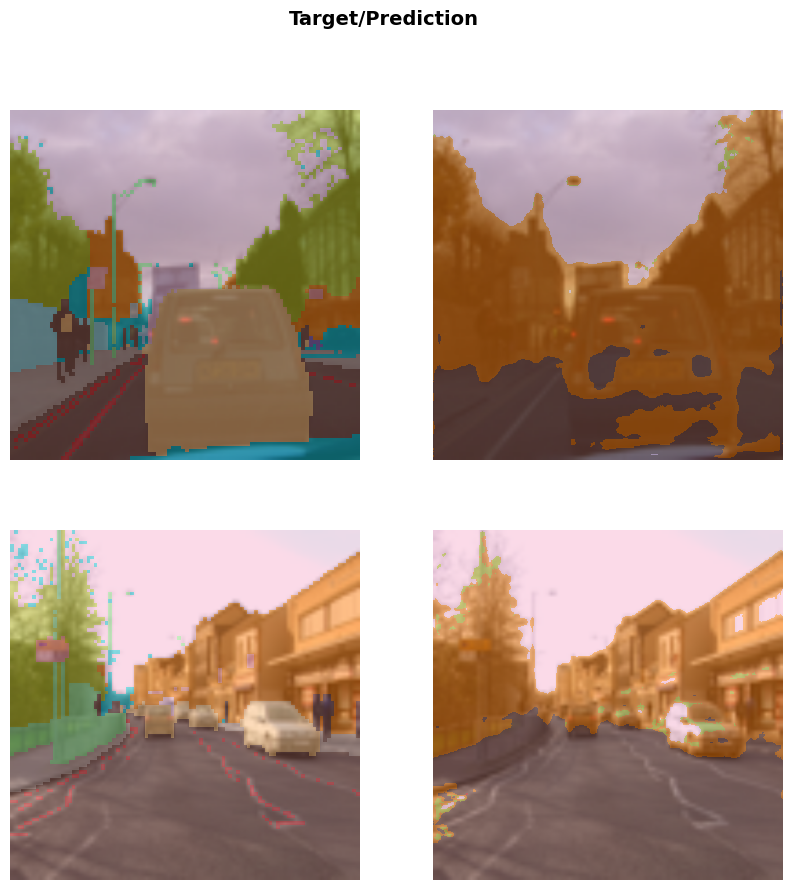

In [ ]:
learn.show_results(max_n=2, figsize=(10, 10))

In [ ]:
image_path = 'path/to/your/image.jpg'
img = PIL.Image.open(image_path)
pred_mask, _, _ = learn.predict(img)
pred_mask.show(figsize=(5, 5))

### **Potential Future Work**
---

Image segmentation is a challenging task that requires balancing model complexity, dataset size, and computation time. Here are some ideas for improving on these results:

* Training with the full CamVid dataset or another image segmentation dataset.

* Fine-tuning the pre-trained model. This project used a pre-trained ResNet34 as the backbone of the UNet model. However, there are many other pre-trained models available that may work better for this specific task. Consider trying a different model, such as ResNet50 or VGG16, and fine-tuning the model on the segmentation dataset.


<a name="p4"></a>

---
## **Part 4: Generating Wikipedia Entries**
---

In this section, you will apply what you learned about generating text by training a model on 30,000 sentences from Wikipedia as of 2021. This text has been downloaded from [https://wortschatz.uni-leipzig.de/en/download/English](https://wortschatz.uni-leipzig.de/en/download/English), which also contains the entries in several other languages as well as other corpora from the internet.

<br>


**Run the code provided below to import the dataset.**

In [ ]:
path = untar_data(URLs.WIKITEXT_TINY)
train_df = pd.read_csv(path/'train.csv', header=None, names=['text'])
dls = TextDataLoaders.from_df(train_df,
                              text_col='text',
                              is_lm=True,
                              valid_pct=0.1,
                              bs=64)

#### **Problem #4.1: Define a pre-trained language model learner**



You'll use the function `language_model_learner()` which works very similarly to `text_classifier_learner()`. Pass the following inputs to the model:
* `dls`
* `AWD_LSTM`
* `metrics=[accuracy, Perplexity()]`,
* `wd=0.1`

Finally, you can use a method called `to_fp16()` at the end of the model definition to have the model work in single precision, which can save a lot of training time.

In [ ]:
learn = language_model_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

#### **Problem #4.2: Train your model**


In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.213851,3.490750,0.379244,32.810551,03:12


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.156602,3.468580,0.379642,32.091148,03:42
1,3.085423,3.461913,0.379659,31.877890,03:29
2,3.079332,3.462044,0.379578,31.882076,02:53
3,3.015193,3.463581,0.380028,31.931120,03:09
4,2.964175,3.464574,0.379882,31.962835,03:21


If you are happy with your model, we recommend saving it so you don't have to re-train it again later. The code for saving the model is provided for you below.

In [ ]:
learn.save('fine_tuned_wikitext_tiny')

Path('models/fine_tuned_wikitext_tiny.pth')

Below is the code to load the model again. Only the model weights are saved, so when using `learn.load()` make sure you first define the model again.

In [ ]:
learn.load('fine_tuned_wikitext_tiny')

#### **Problem #4.3: Generate Text**


We have provided a function below that you can use to generate text. The inputs are:
* prompt -> A string that you want the model to generate text at the end of
* n_words -> The number of words the model should generate
* temperature -> A parameter that represents the amount of "randomness" in the model's response

**Run the cell below to set up the function.**

In [ ]:
def generate_text(prompt, n_words=20, temperature=1.0):
    return learn.predict(prompt, n_words, temperature=temperature)

In [ ]:
prompt = "Chicago is a place where"
predicted_text = generate_text(prompt,30,0.75)
print(predicted_text)

Chicago is a place where the city is depicted in the novel , in which the town is in Prague . 
▁
▁ = = History = = 
▁
▁ Sarnia is the oldest


### **Potential Future Work**
---

Text generation can be a tricky task that can be extremely dependent on the framing of the problem, the dataset available, the models used, and more. Consider some of the following ideas for improving on these results:

* Training with the full Wikitext dataset or another language model dataset.

* Hyperparameter tuning or using a different pre-trained model, maybe a transformer model.

* Can you think of how modify this code to make a chatbot?

# End of notebook
---
© 2024 The Coding School, All rights reserved